<a href="https://colab.research.google.com/github/goerlitz/nlp-classification/blob/main/notebooks/10kGNAD/colab/21d_10kGNAD_optuna_trial_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Optuna Studies and Trials

Aggregates and displays studies and trials found in a optuna database 

**Overview of all Studies**
* trial states and hyperparam distribution settings
* visualization of best trials

**Study Details**
* parallel plot of hyperparameters
* hyperparameter importance
* evaluation metrics plots
* training progress

In [1]:
!pip install -q --upgrade optuna >/dev/null

In [2]:
import pandas as pd
import optuna
import matplotlib.pyplot as plt

## Connect Google Drive

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Database Connection

In [4]:
db_path = "/content/gdrive/My Drive/Colab Notebooks/nlp-classification/"
db_name = "10kgnad_optuna"
storage = f"sqlite:///{db_path}{db_name}.db"

## Show all Studies

In [5]:
for s in optuna.get_all_study_summaries(storage):
    start = "???" if s.datetime_start is None else s.datetime_start.date()
    print(f"{str(start):>10} {s.n_trials:>4} trials '{s.study_name}'")

2021-12-18  220 trials 'distilbert-base-german-cased'
2021-12-18   70 trials 'distilbert-base-german-cased_bs32'
2021-12-20  171 trials 'distilbert-base-german-cased_multi_mcc'
2021-12-21  103 trials 'distilbert-base-german-cased_epoch2'
2021-12-22   93 trials 'deepset/gbert-base_epoch2_bs16'
2021-12-23   29 trials 'deepset/gbert-base_bs16_epoch234'
2021-12-27  133 trials 'deepset/gbert-base_loss-mcc_bs16_epoch234'
2021-12-30   69 trials 'deepset/gelectra-base_loss-mcc_bs16_epoch234'
2022-01-01  149 trials 'deepset/gelectra-base_loss-f1_bs16_epoch234'
2022-01-05  214 trials 'distilbert-base-german-cased_loss-f1_bs32_epoch23'


## Study Information

In [6]:
study_info = []
study_states = []
study_dist = []

def dist2str(dist: optuna.distributions.BaseDistribution) -> str:
    if isinstance(dist, optuna.distributions.UniformDistribution):
        return f"{dist.low} -> {dist.high}"
    if isinstance(dist, optuna.distributions.LogUniformDistribution):
        return f"{dist.low} -> {dist.high} (log)"
    if isinstance(dist, optuna.distributions.CategoricalDistribution):
        return f"{dist.choices}"
    else:
        return str(dist)

for s in optuna.get_all_study_summaries(storage):
    name = s.study_name
    info = {"study_name": name,
            "start": "???" if s.datetime_start is None else s.datetime_start.date(),
            "directions": len(s.directions)}
    study_info.append(info)

    study = optuna.load_study(name, storage)
    states = pd.Series([t.state for t in study.get_trials()]).value_counts()
    counts = {str(state).split(".")[1]:count for state, count in states.items()}
    study_states.append(counts)

    dist = study.get_trials()[0].distributions
    dist = {k:dist2str(dist[k]) for k in dist.keys()}
    study_dist.append(dist)

pd.concat([pd.DataFrame(study_info),
           pd.DataFrame(study_states).fillna(0).astype(int),
           pd.DataFrame(study_dist),], axis=1).fillna("--")

,study_name,start,directions,COMPLETE,FAIL,RUNNING,PRUNED,label_smoothing_factor,learning_rate,num_train_epochs,per_device_train_batch_size,weight_decay
0,distilbert-base-german-cased,2021-12-18,1,212,4,4,0,0.0 -> 0.1,1e-05 -> 0.0001 (log),"(1,)","(8, 16, 32)",0.001 -> 0.01 (log)
1,distilbert-base-german-cased_bs32,2021-12-18,1,70,0,0,0,0.0 -> 0.1,1e-05 -> 0.0001 (log),"(1,)","(32,)",0.001 -> 0.01 (log)
2,distilbert-base-german-cased_multi_mcc,2021-12-20,2,170,1,0,0,--,1e-05 -> 0.0001 (log),"(1,)","(16, 32)",0.001 -> 0.01 (log)
3,distilbert-base-german-cased_epoch2,2021-12-21,1,100,3,0,0,0.0 -> 0.1,1e-05 -> 0.0001 (log),"(2,)","(8, 16, 32)",0.001 -> 0.01 (log)
4,deepset/gbert-base_epoch2_bs16,2021-12-22,1,86,2,5,0,0.0 -> 0.1,1e-05 -> 0.0001 (log),"(2,)","(16,)",0.001 -> 0.01 (log)
5,deepset/gbert-base_bs16_epoch234,2021-12-23,1,22,1,3,3,--,1e-05 -> 0.0001 (log),"(2, 3, 4)","(16,)",0.001 -> 0.01 (log)
6,deepset/gbert-base_loss-mcc_bs16_epoch234,2021-12-27,2,124,3,6,0,--,1e-05 -> 0.0001 (log),"(2, 3, 4)","(16,)",0.001 -> 0.01 (log)
7,deepset/gelectra-base_loss-mcc_bs16_epoch234,2021-12-30,2,64,2,3,0,--,1e-05 -> 0.0001 (log),"(2, 3, 4)","(16,)",0.001 -> 0.01 (log)
8,deepset/gelectra-base_loss-f1_bs16_epoch234,2022-01-01,2,141,2,6,0,--,6e-05 -> 0.0002 (log),"(2, 3)","(16,)",0.001 -> 0.01 (log)
9,distilbert-base-german-cased_loss-f1_bs32_epoch23,2022-01-05,2,189,15,10,0,--,3e-05 -> 0.0001 (log),"(2, 3)","(32,)","(0.001, 0.0)"


## Best Results of Studies

In [7]:
stats = []
attrs = []
params = []
for s in optuna.get_all_study_summaries(storage):
    study = optuna.load_study(s.study_name, storage)
    for i, t in enumerate(study.best_trials):
        stats.append({"study_name": s.study_name,
                      "start": t.datetime_start.date(),
                    #   "best_count": i+1,
                      "trial_number": t.number,
                      })
        ua = t.user_attrs
        if "eval_result" in ua.keys():
            ua = ua["eval_result"]
        attrs.append(ua)
        params.append(t.params)

best_trials_df = pd.concat([pd.DataFrame(stats),
                            pd.DataFrame(attrs),
                            pd.DataFrame(params)], axis=1)
best_trials_df.drop(inplace=True, columns = [c for c in best_trials_df.columns if "per_second" in c])
best_trials_df.drop(inplace=True, columns = ["epoch"])
best_trials_df.rename(inplace=True, columns = {"num_train_epochs": "epochs",
                                               "per_device_train_batch_size": "bs"})
best_trials_df.sort_values(["study_name", "eval_loss"])

,study_name,start,trial_number,eval_acc,eval_f1,eval_loss,eval_precision,eval_recall,eval_runtime,eval_mcc,label_smoothing_factor,learning_rate,epochs,bs,weight_decay
11,deepset/gbert-base_bs16_epoch234,2021-12-27,21,0.903696,0.897792,0.316875,0.898731,0.898682,19.6023,0.889813,NaN,0.000023,2,16,0.002689
10,deepset/gbert-base_epoch2_bs16,2021-12-22,23,0.905642,0.899409,0.315724,0.901905,0.899116,19.4425,0.892042,0.000021,0.000018,2,16,0.006918
18,deepset/gbert-base_loss-mcc_bs16_epoch234,2021-12-30,103,0.911479,0.909482,0.296962,0.907637,0.912236,19.7894,0.898739,NaN,0.000019,4,16,0.005337
15,deepset/gbert-base_loss-mcc_bs16_epoch234,2021-12-29,61,0.911479,0.909316,0.301066,0.908046,0.911541,19.4401,0.898755,NaN,0.000018,4,16,0.001702
17,deepset/gbert-base_loss-mcc_bs16_epoch234,2021-12-30,102,0.911479,0.908405,0.303882,0.908825,0.909129,19.8021,0.898771,NaN,0.000018,3,16,0.001534
19,deepset/gbert-base_loss-mcc_bs16_epoch234,2021-12-30,105,0.911479,0.909415,0.313906,0.909297,0.911132,19.8440,0.898838,NaN,0.000045,3,16,0.004830
12,deepset/gbert-base_loss-mcc_bs16_epoch234,2021-12-28,41,0.912451,0.912317,0.314190,0.914961,0.910553,19.4145,0.899816,NaN,0.000028,3,16,0.005647
14,deepset/gbert-base_loss-mcc_bs16_epoch234,2021-12-29,58,0.912451,0.912317,0.314190,0.914961,0.910553,19.6822,0.899816,NaN,0.000028,3,16,0.005647
13,deepset/gbert-base_loss-mcc_bs16_epoch234,2021-12-29,54,0.913424,0.911337,0.324939,0.911512,0.911907,19.6358,0.900918,NaN,0.000038,3,16,0.004779
16,deepset/gbert-base_loss-mcc_bs16_epoch234,2021-12-29,81,0.914397,0.911470,0.329660,0.910227,0.914572,19.5988,0.902149,NaN,0.000037,4,16,0.006303


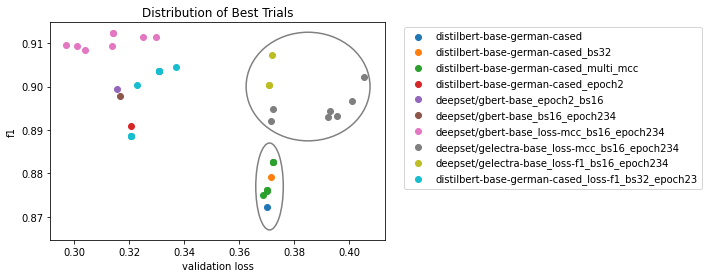

In [8]:
from matplotlib.patches import Ellipse
import seaborn as sns
pal = sns.color_palette("tab10", 10)

for i, s in enumerate(best_trials_df.study_name.unique()):
    df = best_trials_df[lambda x: x["study_name"] == s]
    plt.scatter(df.eval_loss, df.eval_f1, label=s, color=pal[i%10])


ax = plt.gca()
ax.add_patch(Ellipse(xy=(0.371, 0.877), width=0.01, height=0.02, edgecolor='gray', fc='None', lw=1.5))
ax.add_patch(Ellipse(xy=(0.385, 0.9), width=0.045, height=0.025, edgecolor='gray', fc='None', lw=1.5))

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.xlabel("validation loss")
plt.ylabel("f1")
plt.title("Distribution of Best Trials");

In [9]:
# optuna.delete_study('distilbert-base-german-cased_multi_epoch234', storage)
[s.study_name for s in optuna.get_all_study_summaries(storage)]

['distilbert-base-german-cased',
 'distilbert-base-german-cased_bs32',
 'distilbert-base-german-cased_multi_mcc',
 'distilbert-base-german-cased_epoch2',
 'deepset/gbert-base_epoch2_bs16',
 'deepset/gbert-base_bs16_epoch234',
 'deepset/gbert-base_loss-mcc_bs16_epoch234',
 'deepset/gelectra-base_loss-mcc_bs16_epoch234',
 'deepset/gelectra-base_loss-f1_bs16_epoch234',
 'distilbert-base-german-cased_loss-f1_bs32_epoch23']

## Load Study

In [10]:
# study = optuna.load_study('distilbert-base-german-cased_epoch2', storage)
# study = optuna.load_study('distilbert-base-german-cased_multi_mcc', storage)
# study = optuna.load_study('deepset/gbert-base_loss-mcc_bs16_epoch234', storage)
# study = optuna.load_study('deepset/gelectra-base_loss-mcc_bs16_epoch234', storage)
# study = optuna.load_study('deepset/gelectra-base_loss-f1_bs16_epoch234', storage)
study = optuna.load_study('distilbert-base-german-cased_loss-f1_bs32_epoch23', storage)

## Analyze Complete Trials

In [11]:
from optuna.trial import TrialState

complete_trials = [t for t in study.get_trials() if t.state==TrialState.COMPLETE]

In [12]:
def get_metrics(trial):
    attrs = trial.user_attrs
    if "eval_result" in attrs.keys():
        attrs = attrs["eval_result"]
    return attrs

# create DataFrames
if len(complete_trials) > 0:
    index = [t.number for t in complete_trials]
    trial_metrics_df = pd.DataFrame([get_metrics(t) for t in complete_trials], index=index)
    trial_params_df = pd.DataFrame([t.params for t in complete_trials], index=index)
    trial_df = pd.concat([trial_params_df, trial_metrics_df], axis=1).sort_values("eval_loss", ascending=True)
    best = [t.number for t in study.best_trials]
    trial_df["best"] = trial_df.index.isin(best)
    main_metric = "eval_loss"
    trial_params_df[main_metric] = trial_metrics_df[main_metric]
    display(trial_df.head(10))

,learning_rate,num_train_epochs,per_device_train_batch_size,weight_decay,eval_loss,eval_acc,eval_f1,eval_precision,eval_recall,eval_mcc,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,best
30,0.000083,2,32,0.000,0.320861,0.890078,0.888674,0.889285,0.888478,0.874091,9.7753,105.163,3.376,2.0,True
129,0.000083,2,32,0.000,0.320861,0.890078,0.888674,0.889285,0.888478,0.874091,9.7214,105.746,3.395,2.0,True
127,0.000083,2,32,0.000,0.320861,0.890078,0.888674,0.889285,0.888478,0.874091,9.7369,105.577,3.389,2.0,True
195,0.000060,2,32,0.001,0.322731,0.901751,0.900347,0.903356,0.898522,0.887522,9.7266,105.689,3.393,2.0,True
175,0.000083,2,32,0.001,0.323250,0.889105,0.887134,0.887508,0.887273,0.873003,9.9316,103.508,3.323,2.0,False
172,0.000083,2,32,0.001,0.323250,0.889105,0.887134,0.887508,0.887273,0.873003,9.8107,104.783,3.364,2.0,False
165,0.000068,2,32,0.001,0.326443,0.895914,0.894377,0.896592,0.893662,0.880915,9.8199,104.685,3.361,2.0,False
163,0.000078,3,32,0.000,0.328529,0.895914,0.891078,0.891902,0.892507,0.880937,9.8192,104.693,3.361,3.0,False
194,0.000068,2,32,0.000,0.328920,0.892996,0.891986,0.894390,0.891123,0.877572,9.7450,105.490,3.386,2.0,False
92,0.000068,2,32,0.000,0.328920,0.892996,0.891986,0.894390,0.891123,0.877572,9.7915,104.989,3.370,2.0,False


In [13]:
import plotly.express as px

fig = px.parallel_coordinates(trial_df[trial_params_df.columns], color=main_metric, 
                             color_continuous_scale=px.colors.sequential.Oryel)
fig.update_layout(autosize=False, width=700, height=350)
fig.show()

In [14]:
# fig = optuna.visualization.plot_parallel_coordinate(study, target=lambda trial: trial.user_attrs["eval_loss"], target_name="loss")
# fig.update_layout(autosize=False, width=700, height=350)
# fig.show()

In [15]:
# optuna.visualization.plot_contour(study)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



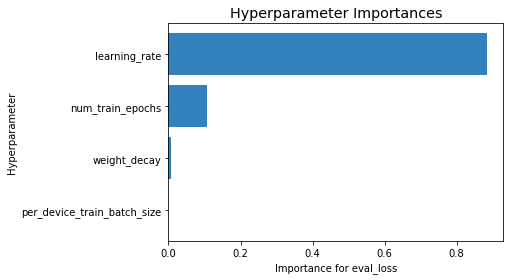

In [16]:
# from optuna.visualization import plot_param_importances
from optuna.visualization.matplotlib import plot_param_importances

fig = plot_param_importances(
    study, target=lambda t: t.values[0], target_name="eval_loss"
)
# fig.update_layout(autosize=False, width=800, height=350)
# fig.show()

In [17]:
def get_loss(trial):
    """Handle different data format versions"""
    if "eval_result" in trial.user_attrs.keys():
        return trial.user_attrs["eval_result"]["eval_loss"]
    else:
        return trial.user_attrs["eval_loss"]

In [18]:
fig = optuna.visualization.plot_slice(study, target=get_loss, target_name="loss")
fig.update_layout(autosize=False, width=900, height=350)
fig.show()

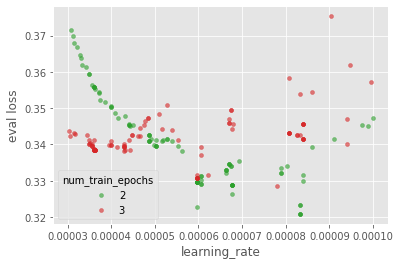

In [19]:
import seaborn as sns

pal = sns.color_palette("tab10", 10)

# plt.scatter(trial_df.eval_loss, trial_df.learning_rate, c=trial_df.best, cmap="Set1_r", alpha=0.6, s=8);
field = "num_train_epochs"
for f in sorted(trial_df[field].unique()):
    df = trial_df[lambda x: x[field] == f]
    plt.scatter(df.learning_rate, df.eval_loss, alpha=0.6, s=16, label=f, color=pal[f])

# plt.gca().set_xscale('log')
plt.legend(title=field)
plt.ylabel("eval loss")
plt.xlabel("learning_rate");

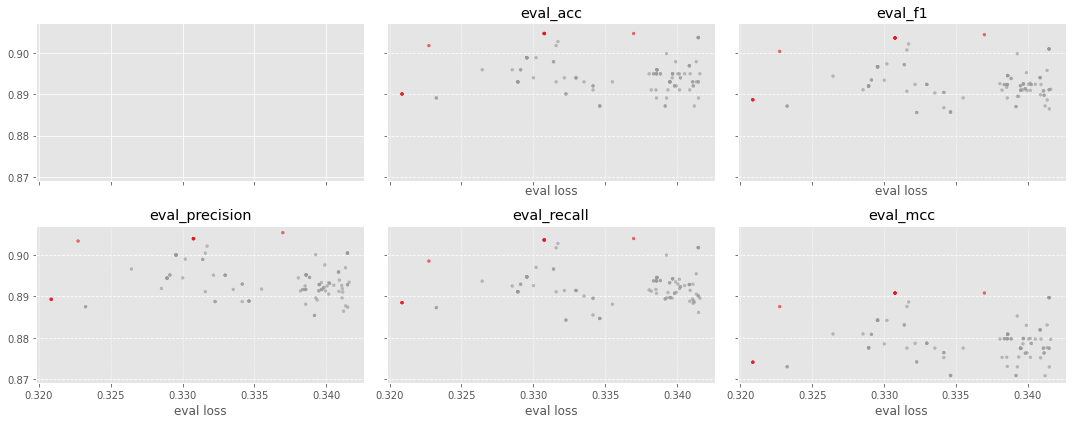

In [20]:
fig, axs = plt.subplots(2, 3, figsize=(15,6), sharex=True, sharey=True)

exclude = ["eval_runtime", "eval_samples_per_second", "eval_steps_per_second"]
metrics = [m for m in trial_metrics_df.columns if m not in exclude]

# only focus on low loss trials
loss_df = trial_df[lambda x: x.eval_loss < x.eval_loss.mean()]

for col, ax in zip(metrics, axs.flatten()):
    if col == "eval_loss":
        continue
    ax.scatter(loss_df.eval_loss, loss_df[col], c=loss_df.best, cmap="Set1_r", alpha=0.6, s=8);
    ax.set_title(col)
    ax.set_xlabel("eval loss")
    ax.grid(axis='y', linestyle='--', zorder=1)
    ax.grid(axis='x', linestyle=':', zorder=1)

plt.tight_layout()

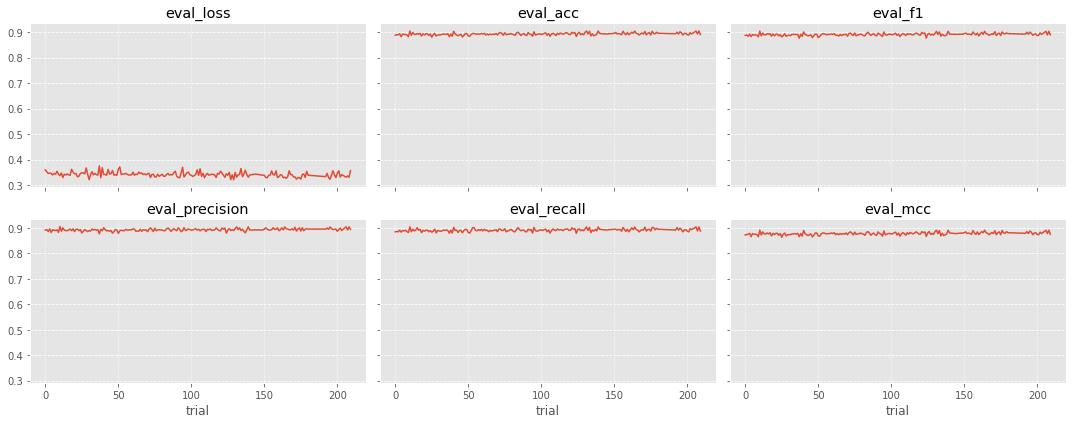

In [21]:
fig, axs = plt.subplots(2, 3, figsize=(15,6), sharex=True, sharey=True)

for col, ax in zip(metrics, axs.flatten()):
    trial_df[col].sort_index().plot(ax=ax)
    ax.set_title(col)
    ax.set_xlabel("trial")
    ax.grid(axis='y', linestyle='--', zorder=1)
    ax.grid(axis='x', linestyle=':', zorder=1)

plt.tight_layout()

## Single Trial - Extract data logged during train

In [22]:
running_trials = [t for t in study.get_trials() if t.state==TrialState.RUNNING]
data = complete_trials[-1].user_attrs
if "eval_result" in data.keys():
    log_df = pd.DataFrame(data.values(), index=data.keys())[lambda x: x.index != "eval_result"]
    log_df.index = log_df.index.astype(int)
    log_df.sort_index(inplace=True)
    display(log_df)

,eval_loss,eval_acc,eval_f1,eval_precision,eval_recall,eval_mcc,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,lr
57,0.975673,0.738327,0.685700,0.760769,0.666344,0.700399,9.7056,105.918,3.400,0.20,3.209463e-05
114,0.649840,0.820039,0.815644,0.849818,0.798592,0.794969,9.7029,105.947,3.401,0.39,2.858332e-05
171,0.531696,0.833658,0.834373,0.839555,0.841629,0.811825,9.7223,105.736,3.394,0.59,2.507201e-05
228,0.449956,0.866732,0.867448,0.867917,0.870936,0.847665,9.7184,105.779,3.396,0.79,2.156069e-05
285,0.430844,0.859922,0.863756,0.868635,0.865732,0.840688,9.7024,105.953,3.401,0.99,1.804938e-05
342,0.401221,0.867704,0.868300,0.875375,0.862993,0.848439,9.6901,106.087,3.406,1.18,1.453807e-05
399,0.384354,0.869650,0.868035,0.867922,0.869788,0.850930,9.7158,105.807,3.397,1.38,1.102676e-05
456,0.367098,0.890078,0.889193,0.893275,0.886538,0.874112,9.7129,105.839,3.398,1.58,7.515442e-06
513,0.376412,0.874514,0.871989,0.873566,0.874540,0.856939,9.7008,105.970,3.402,1.78,4.004129e-06
570,0.356438,0.891051,0.890143,0.893447,0.887444,0.875153,9.6904,106.084,3.405,1.97,4.928159e-07


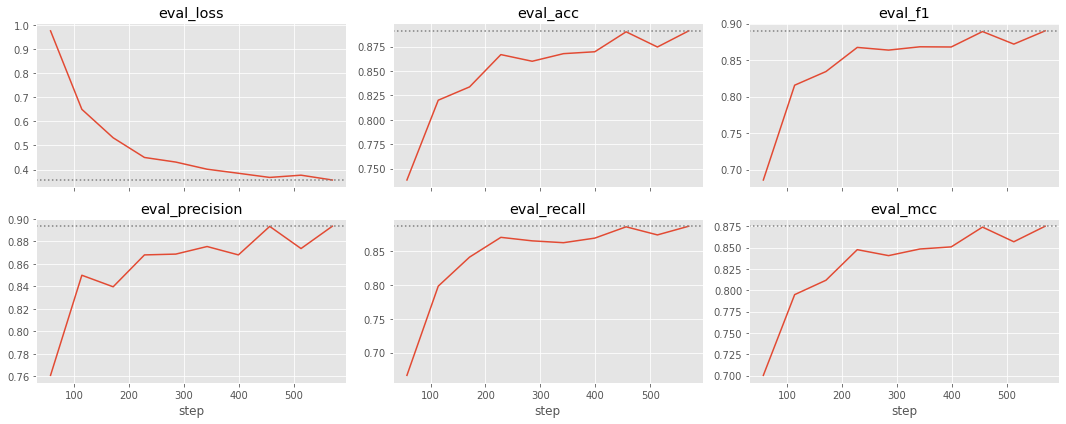

In [23]:
fig, axs = plt.subplots(2, 3, figsize=(15,6), sharex=True)

for col, ax in zip(metrics, axs.flatten()):
    log_df[col][0:-1].plot(ax=ax).axhline(log_df[col].values[-1], c="grey", linestyle=":")
    ax.set_title(col)
    ax.set_xlabel("step")
    # ax.grid(axis='y', linestyle='--', zorder=1)
    # ax.grid(axis='x', linestyle=':', zorder=1)

plt.tight_layout()

## Plot Learning Rate

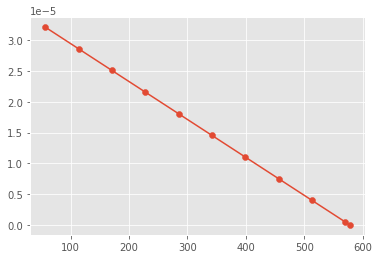

In [24]:
log_df["lr"].plot()
plt.scatter(log_df["lr"].index, log_df["lr"]);

# Plot all Loss Curves

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



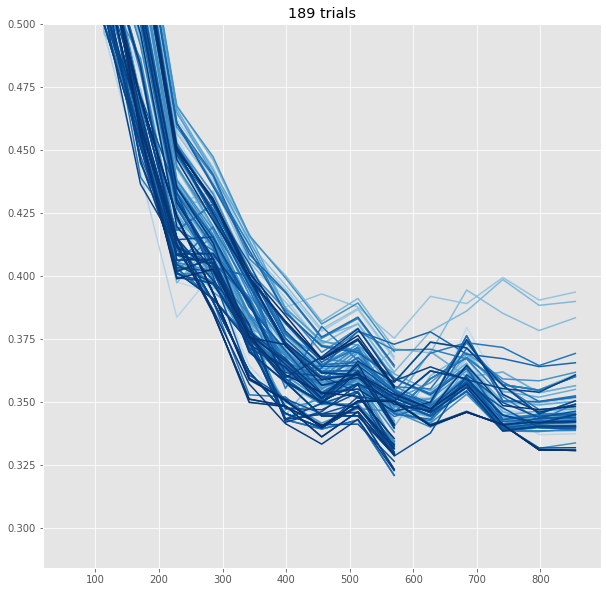

In [25]:
# https://stackoverflow.com/questions/52758070/color-map-to-shades-of-blue-python
# https://stackoverflow.com/questions/38208700/matplotlib-plot-lines-with-colors-through-colormap

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(10,10))

n = len(complete_trials)
colors = plt.cm.Blues(np.linspace(0.25,1,n))

count = 0
for i, t in enumerate(complete_trials):
    if not "eval_result" in t.user_attrs.keys():
        continue
    count += 1
    data = t.user_attrs
    loss_df = pd.DataFrame(data.values(), index=data.keys())[lambda x: x.index != "eval_result"]
    loss_df.index = loss_df.index.astype(int)
    loss_df.sort_index(inplace=True)
    ax.plot(loss_df["eval_loss"][0:-1], c=colors[i])
    # loss_df["eval_loss"].plot(ax=ax, cmap="Blues")
    # print(t.number, loss_df["eval_loss"])
plt.ylim([None,0.5])
plt.title(f"{count} trials");